Notebook Color Scheme: 


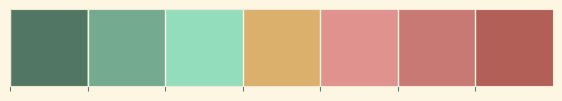

In [1]:
# 1. Handle datasets
import io
import os
import gc
import cv2
import time
import random
import pydicom
import dicomsdl
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import tifffile as tiff
import imageio.v3 as iio
import SimpleITK as sitk
from pathlib import Path
from tqdm.auto import tqdm
import multiprocessing as mp
from collections import Counter
from joblib import Parallel, delayed
from pydicom.pixel_data_handlers.util import apply_voi_lut

# 2. Visualize datasets
import datetime as dtime
from datetime import datetime
import itertools
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px
import plotly.figure_factory as pff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html

# 3. Preprocess datasets
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer, KNNImputer
## import iterative impute
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
## fastai
# from fastai.data.all import *
# from fastai.vision.all import *

# 4. machine learning
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.model_selection import StratifiedKFold, GroupKFold
## for classification
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.preprocessing import KBinsDiscretizer
from xgboost import XGBClassifier

# 5. Deep Learning
## Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import ViTModel, ViTFeatureExtractor, ViTForImageClassification

## Torch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50, ResNet50_Weights
from torchvision import datasets, transforms

# 6. metrics
import optuna
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.metrics import f1_score, r2_score
from sklearn.metrics import classification_report

# 7. ignore warnings   
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# 8. For displaying and wandb
import wandb
# wandb.login()
plt.style.use("Solarize_Light2")
plt.rcParams.update({'font.size': 16})

# 0. Customization
parent_dir = r"E:\rsna-breast-cancer-detection"
WANDB_PROJ_NAME = "RSNA_Breast_Cancer_Detection"
CONFIG = {
    'competition': 'RSNA_Breast_Cancer',
    '_wandb_kernel': 'aot'
}

my_colors = ['#517664', '#73AA90', '#94DDBC', '#DAB06C',
             '#DF928E', '#C97973', '#B25F57']
CMAP1 = ListedColormap(my_colors)
print("Notebook Color Scheme: ")
sns.palplot(sns.color_palette(my_colors))
plt.show()

In [2]:
import importlib
import utils
importlib.reload(utils)

from utils import set_seed, show_stacked_images, show_values_on_bars
from utils import save_dataset_artifact, create_wandb_plot, create_wandb_hist

In [3]:
train = pd.read_csv(os.path.join(parent_dir, "train.csv"))
test = pd.read_csv(os.path.join(parent_dir, "test.csv"))

train_image_path = os.path.join(parent_dir, "train_image_ROI_processed_jp2000_512")
# train_image_path = os.path.join(parent_dir, "train_image_processed_cv2_512")

all_paths = []
for k in tqdm(range(len(train))):
    row = train.iloc[k, :]
    all_paths.append(
        os.path.join(
            train_image_path, str(row.patient_id), f"{str(row.image_id)}.jp2"
        ) 
    )
    
train['path'] = all_paths

train = train[
    ['patient_id', 'image_id', 'laterality', 'view', 'age', 'implant',
     "cancer", "path"]
]

le_laterality = LabelEncoder()
le_view = LabelEncoder()

train['laterality'] = le_laterality.fit_transform(train['laterality'])
train['view']       = le_view.fit_transform(train['view'])

train['age'] = train['age'].fillna(58)

train.to_csv(os.path.join(parent_dir, "train_preprocessed.csv"), index=False)

  0%|          | 0/54706 [00:00<?, ?it/s]

In [4]:
# Seed
set_seed()
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now: ', DEVICE)

# Read in Data
train = pd.read_csv(os.path.join(parent_dir, "train_preprocessed.csv"))

# ====== GLOBAL PARAMS =======
csv_columns = ["laterality", "view", "age", "implant"]
no_columns = len(csv_columns)
output_size = 1

Device available now:  cuda


Batch: 0 
 Image: torch.Size([12, 3, 224, 224]) 
 Meta: tensor([[ 0.,  1., 61.,  0.],
        [ 0.,  5., 61.,  0.],
        [ 1.,  5., 61.,  0.],
        [ 1.,  1., 61.,  0.],
        [ 0.,  1., 55.,  0.],
        [ 0.,  5., 55.,  0.],
        [ 1.,  1., 55.,  0.],
        [ 1.,  5., 55.,  0.],
        [ 0.,  1., 75.,  0.],
        [ 0.,  5., 75.,  0.],
        [ 1.,  1., 75.,  0.],
        [ 1.,  5., 75.,  0.]], device='cuda:0') 
 Targets: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')


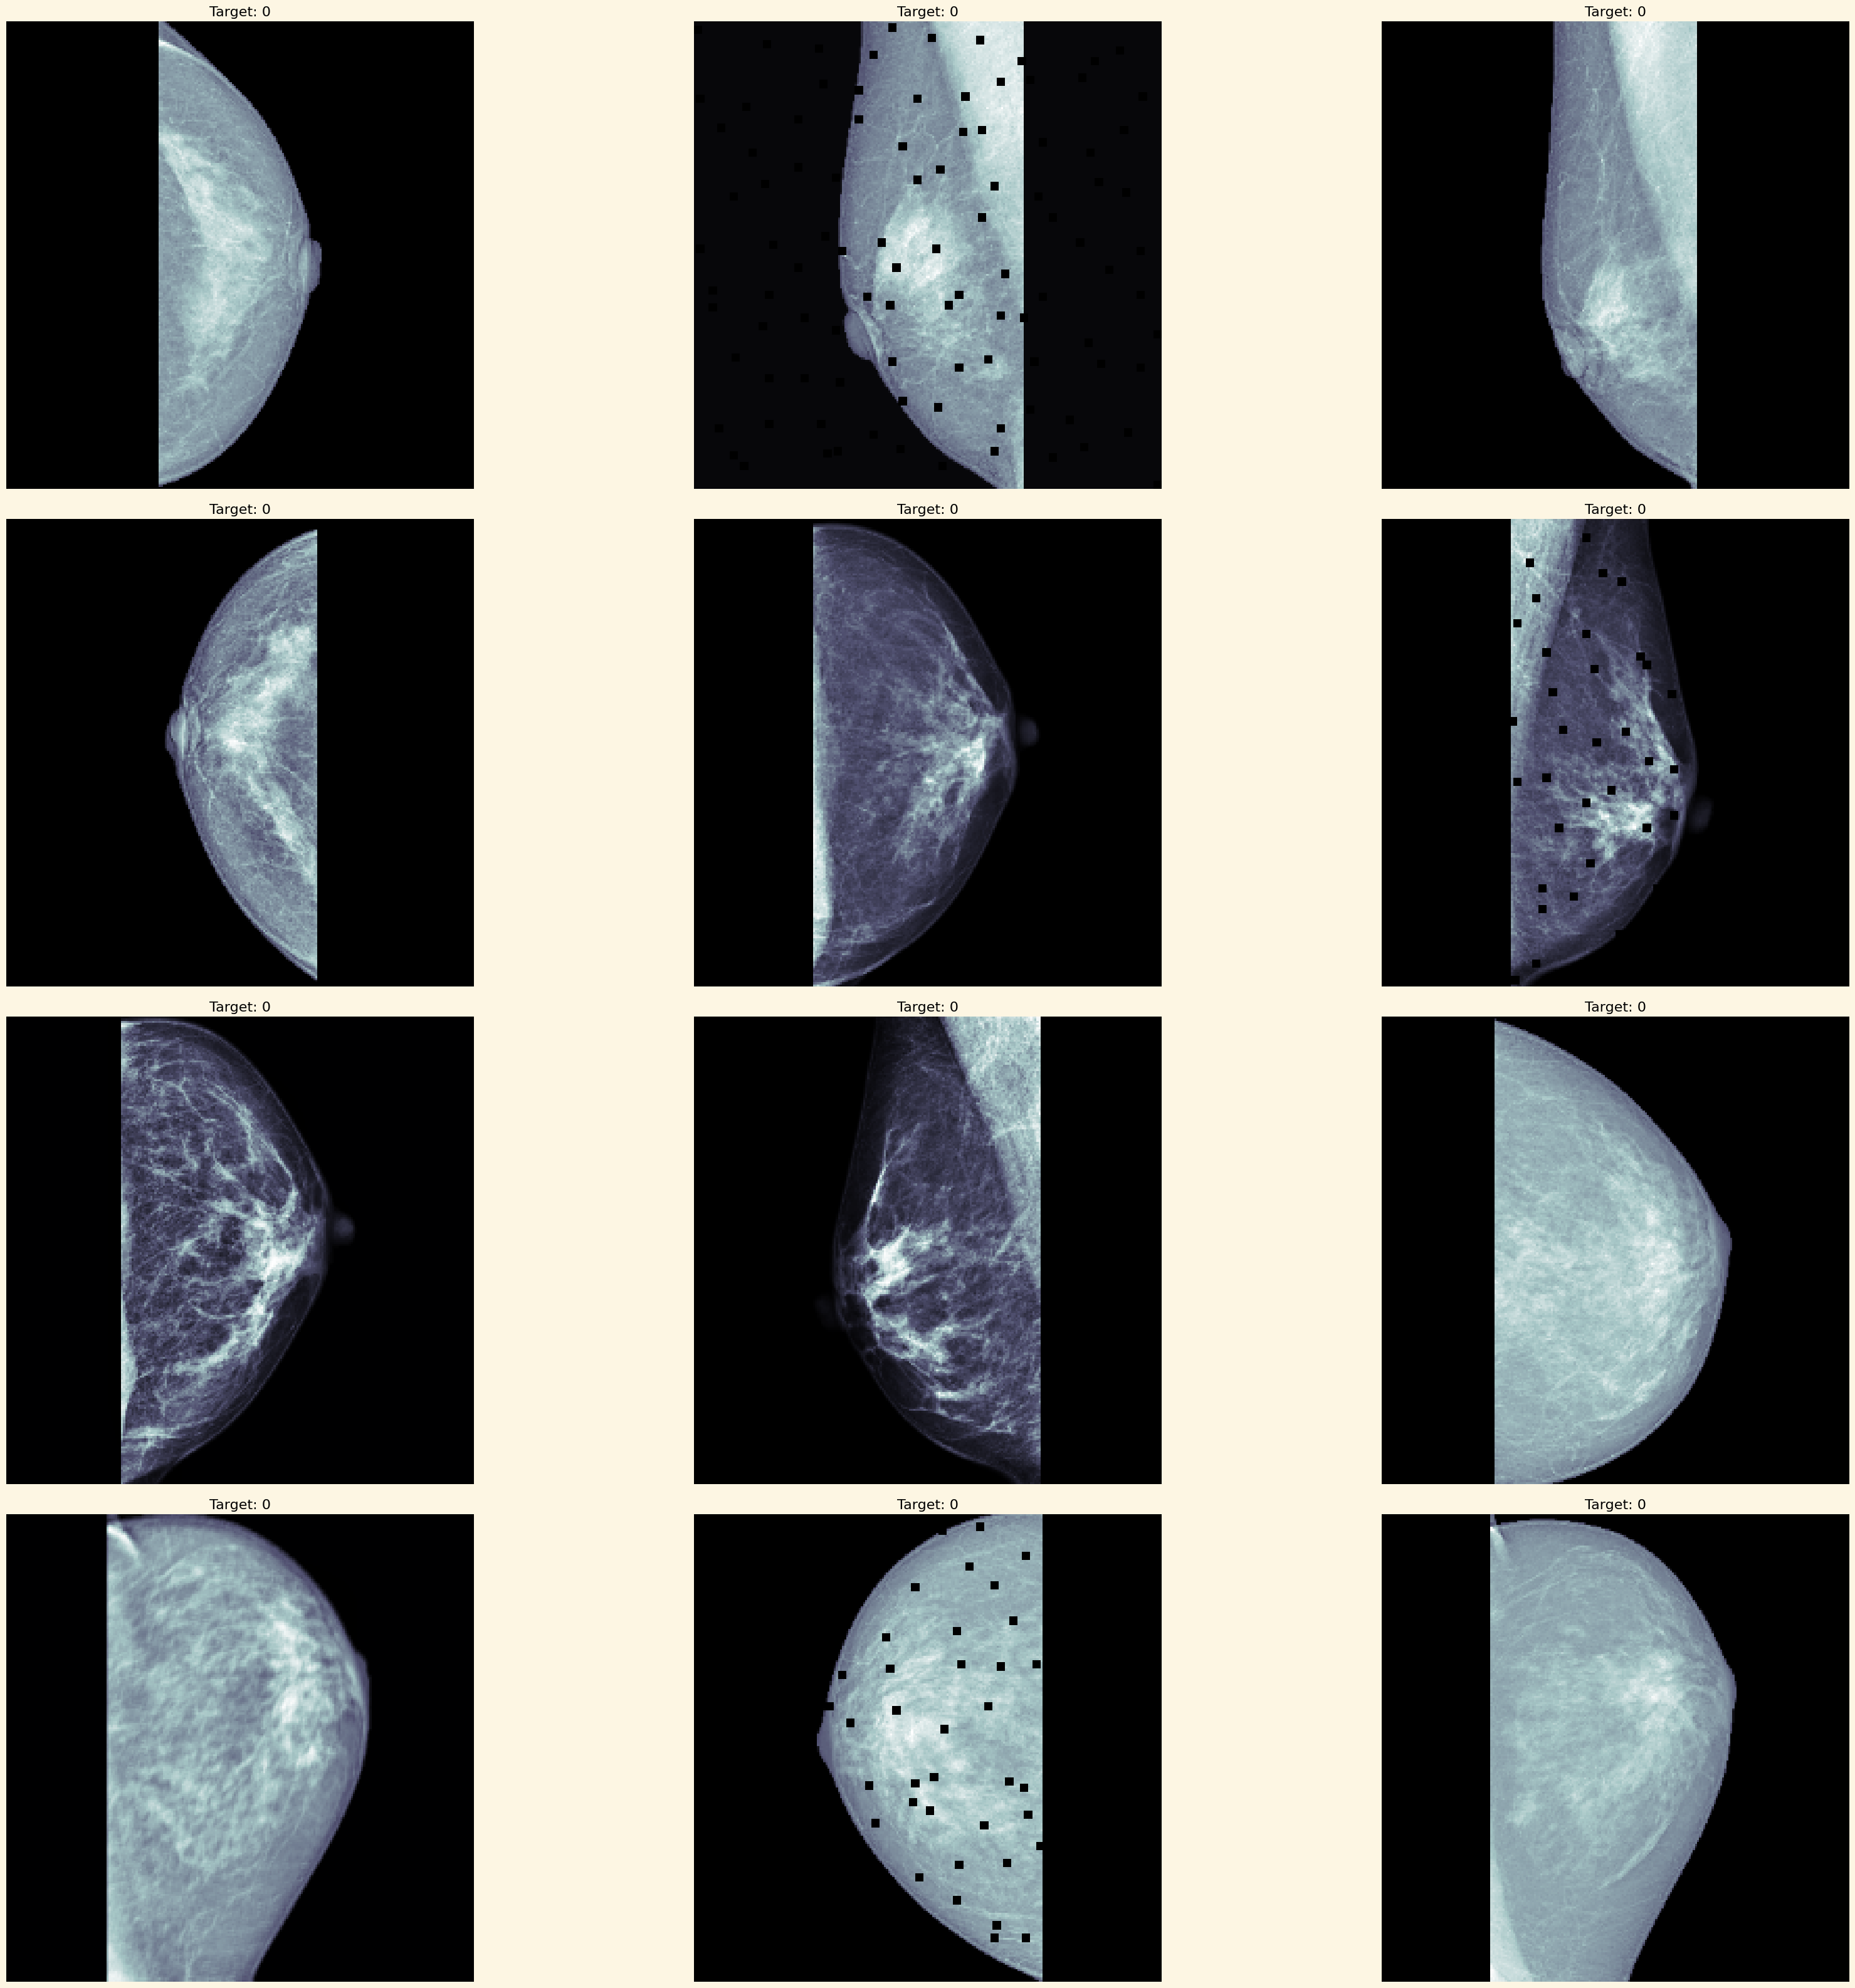

In [5]:
from utils import transforms    # augmentation functions

def data_to_device(data):
    image, metadata, targets = data.values()
    return image.to(DEVICE), metadata.to(DEVICE), targets.to(DEVICE)

class RSNADataset(Dataset):
    
    def __init__(self, dataFrame, isTrain = True, transforms=None):
        self.dataFrame, self.isTrain = dataFrame, isTrain
        self.metaData = self.dataFrame[csv_columns].to_numpy(dtype=np.float32)
        self.transforms = transforms  ## Data Augmentation
    
    def __len__(self):
        return len(self.dataFrame)
    
    def __getitem__(self, index):
        try:
            # Dealing with tabular
            csv_data = self.metaData[index]
            csv_data = torch.tensor(csv_data, dtype=torch.float32)
            
            # Dealing with images
            image_path = self.dataFrame['path'][index]
            if not os.path.exists(image_path):  # Check if image exists
                return self.__getitem__((index + 1) % len(self))
            
            image = cv2.imread(image_path)
            if image is None:
                return self.__getitem__((index + 1) % len(self))  # Pass if img is None
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            # == AUGMENTATION ==
            # Dealing with imbalanced data
            label = self.dataFrame.loc[index]['cancer']
            isMinority = (label == 1)
            
            # == AUGMENTATION ==
            if self.isTrain:
                image = self.transforms(
                    isMinority=isMinority, isTrain=True
                )(image=image)['image']
            else:
                image = self.transforms(isTrain=False)(image=image)['image']
            
            if self.isTrain:
                return {
                    "image": image, 
                    "meta": csv_data, 
                    "target": self.dataFrame['cancer'][index]
                }
            else:
                return {
                    "image": image, 
                    "meta": csv_data, 
                }
        except Exception as e:
            print(f"[ERROR] Failed at index {index}: {e}")
            if self.isTrain:
                return {
                    "image": torch.zeros(3, 224, 224), 
                    "meta": torch.zeros(no_columns),
                    "target": torch.tensor(0)
                }
            else:
                return {
                    "image": torch.zeros(3, 224, 224), 
                    "meta": torch.zeros(no_columns), 
                }

# == Sanity Check ==
train_data = train.reset_index(drop=True).head(12)
dataset = RSNADataset(
    dataFrame = train_data, 
    isTrain = True, 
    transforms=transforms
)
dataLoader = DataLoader(dataset, batch_size=64, shuffle=False, pin_memory=True)

for i, data in enumerate(dataLoader):
    image, meta, targets = data_to_device(data)
    print(f"Batch: {i} \n Image: {image.shape} \n Meta: {meta} \n Targets: {targets}")
    print("="*50)
    
    show_stacked_images(image, targets)

In [6]:
from utils import EffNetV2Network

# == Sanity Check ==
model_example_2 = EffNetV2Network(outputSize=output_size,
                                no_columns=no_columns).to(DEVICE)

out = model_example_2(image, meta, prints=True)
criterion_example = nn.BCEWithLogitsLoss()
loss = criterion_example(out, targets.unsqueeze(1).float())

print("="*50)
print(f"Loss = {loss.item()}")

Input Image Shape: torch.Size([12, 3, 224, 224]) 
 Input Metadata Shape: torch.Size([12, 4])
Features image shape: torch.Size([12, 1280])
Metadata shape: torch.Size([12, 250])
Concatenated data: torch.Size([12, 1530])
Out shape: torch.Size([12, 1])
Loss = 0.5598163604736328


## Training
The below code is basically the same as the last one in '3_Train_Resnet' ipynb file, but with different augmentations and some parameters.

In [7]:
def add_in_file(text, f, trial):
    with open(f"logs_{VERSION}_trial_{trial}.txt", "a+") as f:
        print(text, file=f)

In [8]:
FOLDS = 3
EPOCHS = 20
MIN_THRESHOLD_EPOCHS = 5
WD = 1e-4
PATIENCE = 3
LR_PATIENCE = 0.9
LR_FACTOR = 0.6

In [ ]:
from sklearn.model_selection import GroupKFold
from scipy.stats import mode

# =======================================
# 1. Define Ensembling Function (Majority Voting / Soft Voting)
# =======================================
def ensemble_predict(models, test_data, voting_type='soft'):
    models = [model.to(DEVICE).eval() for model in models]
    all_preds = []

    with torch.no_grad():
        for model in models:
            predictions = model(test_data)
            all_preds.append(predictions)

    if voting_type == 'soft':
        avg_preds = torch.stack(all_preds).mean(dim=0)
        return avg_preds

    elif voting_type == 'hard':
        preds = [torch.argmax(pred, dim=1) for pred in all_preds]
        stacked_preds = torch.stack(preds)
        final_preds, _ = mode(stacked_preds, dim=0)
        return final_preds.squeeze(0)

# =======================================
# 2. Modify `train_folds` to save top 3 models
# =======================================
def train_folds(model, train_original, lr, batch_size, trial, epochs=3):
    
    topModels = []

    def saveBestModel(foldNum, epochNum, valid_acc, f1Score, best_roc, model=model, VERSION=VERSION):
        model_name = f"{VERSION}_Fold{foldNum}_Epoch{epochNum}_ValidAcc{valid_acc:.3f}_F1{f1Score:.3f}_ROC{best_roc:.3f}.pth"
        torch.save(model.state_dict(), model_name)
        
        topModels.append((model_name, best_roc))
        topModels.sort(key=lambda x: x[1], reverse=True)
        
        if len(topModels) > 3:
            removedModel = topModels.pop()
            os.remove(removedModel[0])
            print(f"Deleted worst model: {removedModel[0]}")

    def create_dataloader(dataset, batch_size=32, shuffle=False, sampler=None):
        return DataLoader(dataset, batch_size, shuffle, sampler=sampler, pin_memory=True)

    def trainFunction(epoch):
        model.train()
        total_loss, correct = 0.0, 0.0
        progBar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False)
        
        for data in progBar:
            image, meta, targets = data_to_device(data)
            optimizer.zero_grad()
            out = model(image, meta)
            loss = criterion(out, targets.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            train_preds = torch.round(torch.sigmoid(out))
            correct += (train_preds.cpu() == targets.cpu().unsqueeze(1)).sum().item()
            wandb.log({'train_loss': total_loss})
            progBar.set_description(f'loss: {total_loss:.2f}')

        train_acc = correct / len(train_index)
        wandb.log({"train_acc": train_acc})
        return train_acc, total_loss
    
    def validFunction(epoch, train_acc, total_loss):
        nonlocal best_roc, patience_f
        model.eval()
        preds_tensor = torch.zeros(len(valid_data), 1, device=DEVICE, dtype=torch.float32)
        
        progBar = tqdm(valid_loader, desc=f"Epoch {epoch+1} [Valid]", leave=False)
        with torch.no_grad():
            for k, data in enumerate(progBar):
                image, meta, targets = data_to_device(data)
                out = model(image, meta)
                preds = torch.sigmoid(out)
                preds_tensor[k * image.shape[0]: (k + 1) * image.shape[0]] = preds
                
        pred_bin = torch.round(preds_tensor.cpu())
        valid_labels = valid_data['cancer'].values
        acc = accuracy_score(valid_labels, pred_bin)
        roc = roc_auc_score(valid_labels, preds_tensor.cpu())
        f1 = f1_score(valid_labels, pred_bin)
                
        wandb.log({"valid_acc": acc})
        wandb.log({"valid_roc": roc})
        wandb.log({"valid_F1Score": f1})
        
        duration = str(time.time() - start_time)[:7]
        log = f'{duration} | Epoch: {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Acc_tr: {train_acc:.3f} | Acc_vd: {acc:.3f} | ROC: {roc:.3f} | F1: {f1:.3f}'
        print(log)
        add_in_file(log, f, trial=trial)
        
        scheduler.step(roc)
        
        if best_roc is None or roc > best_roc:
            best_roc = roc
            saveBestModel(foldNum=i+1, epochNum=epoch+1, valid_acc=acc, f1Score=f1, best_roc=best_roc, model=model, VERSION=VERSION)
            print(f"Saved new best model at Epoch {epoch+1}")
            return best_roc, PATIENCE
        else:
            return best_roc, patience_f - 1
    
    with open(f"logs_{VERSION}.txt", "w+") as f:
        print(f"Training with learning rate: {lr} and batch size: {batch_size}")
    
    train_original = train_original.sample(frac=1, random_state=42).reset_index(drop=True)

    group_fold = GroupKFold(n_splits=FOLDS)
    k_folds = group_fold.split(X=np.zeros(len(train_original)), y=train_original['cancer'], groups=train_original['patient_id'].tolist())
    
    for i, (train_index, valid_index) in enumerate(k_folds):
        print(f"-------- Fold: {i+1} --------")
        add_in_file(f"-------- Fold: {i+1} --------", f, trial=trial)
        
        RUN_CONFIG = CONFIG.copy()
        params = dict(model=MODEL, version=VERSION, fold=i, epochs=epochs, batch=batch_size, lr=lr, weight_decay=WD)
        RUN_CONFIG.update(params)
        wandb.init(project=WANDB_PROJ_NAME, config=RUN_CONFIG)
        wandb.watch(model, log_freq=100)
        
        best_roc = None
        patience_f = PATIENCE
        current_model = model
        
        train_data = train_original.iloc[train_index].reset_index(drop=True)
        valid_data = train_original.iloc[valid_index].reset_index(drop=True)
        
        neg, pos = train_data['cancer'].value_counts()
        pos_weight = torch.tensor([neg / pos], dtype=torch.float).to(DEVICE)

        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=WD)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, mode="max", patience=LR_PATIENCE, factor=LR_FACTOR)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
        train = RSNADataset(train_data, isTrain=True, transforms=transforms)
        valid = RSNADataset(valid_data, isTrain=True, transforms=transforms)
        
        class_counts = train_data['cancer'].value_counts()
        class_weights = 1. / class_counts
        sample_weights = train_data['cancer'].map(lambda x: class_weights[x])
            
        sampler = torch.utils.data.WeightedRandomSampler(
            weights=sample_weights.values, 
            num_samples=len(sample_weights), 
            replacement=True
        )
        
        train_loader = create_dataloader(train, sampler=sampler)
        valid_loader = create_dataloader(valid, shuffle=False)
        
        for epoch in range(epochs):
            start_time = time.time()
            train_acc, total_loss = trainFunction(epoch)
            best_roc, patience_f = validFunction(epoch, train_acc, total_loss)
            
            if epoch + 1 > MIN_THRESHOLD_EPOCHS and patience_f == 0:
                msg = f"Early stopping | Best ROC: {best_roc:.4f}"
                print(msg)
                add_in_file(msg, f, trial=trial)
                break
        
        for var_name in ['train', 'valid', 'train_loader', 'valid_loader', 'image', 'targets']:
            if var_name in locals():
                del locals()[var_name]
        gc.collect()
        
        wandb.finish()

    return topModels

# =======================================
# 3. Combine Best Models with Ensembling
# =======================================
def ensemble_models(models, test_data, voting_type='soft'):
    soft_preds = ensemble_predict(models, test_data, voting_type=voting_type)
    return soft_preds

# =======================================
# 4. Utilize all and train
# =======================================

VERSION = 'v6'
MODEL = 'effnetV2'

# Optimization using Optuna
def objective(trial):
    trial_number = trial.number
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [64, 128])
    
    model = EffNetV2Network(outputSize=output_size, no_columns=no_columns).to(DEVICE)
    
    # Train the model and get top models from all folds
    top_models = train_folds(
        model, train_original=train, 
        lr=lr, batch_size=batch_size, trial=trial_number, epochs=EPOCHS
    )
    
    # Combine the top models into an ensemble and get predictions
    ensemble_preds = ensemble_models([model for model, _ in top_models], test_data=test)
    
    # If using ROC-AUC, you can evaluate the performance on the test set (test_df)
    # Assuming `test_df['cancer']` is the true labels for the test set
    true_labels = test['cancer'].values
    roc_score = roc_auc_score(true_labels, ensemble_preds.cpu().numpy())
    
    # Return the ROC score of the ensemble predictions for optimization
    return roc_score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)
print("Best hyperparameters: ", study.best_params)

best_trial = study.best_trial.number
with open(f"logs_{VERSION}_trial_{best_trial}.txt", "r") as f:
    contents = f.read()
    print(contents)

**Observations**:

+ High ROC score implies that the model can distinguish different classes (pos. vs neg.) very well, but ...

+ F1 score shows that at early epochs, the model still not able to perform well. It's like saying a child has potential but you expect it to perform well at early age. As you can see the F1 score +0.1 after 5 epochs. Given more time or computational resources, the model could be very well trained.

+ F1 score increasing noticeably is no longer a myth. This metric can help the model more powerful. Consider: increasing epochs + officially using F1 as an additional feature to measure best models.

+ RTX3060, cuda, effenetV2: training for 2 days, using ~30% of RAM, at Fold 2 + epoch 12, the metrics are looking incredible. Consider: using more powerful GPU + more time & comp. resources.

**The below code has not run yet**

In [ ]:
from sklearn.model_selection import GroupKFold
from scipy.stats import mode

EPOCHS = 50
MIN_THRESHOLD_EPOCHS = 20
PATIENCE = 3

# =======================================
# 1. Define Ensembling Function (Majority Voting / Soft Voting)
# =======================================
def ensemble_predict(models, test_data, voting_type='soft'):
    models = [model.to(DEVICE).eval() for model in models]
    all_preds = []

    with torch.no_grad():
        for model in models:
            predictions = model(test_data)
            all_preds.append(predictions)

    if voting_type == 'soft':
        avg_preds = torch.stack(all_preds).mean(dim=0)
        return avg_preds

    elif voting_type == 'hard':
        preds = [torch.argmax(pred, dim=1) for pred in all_preds]
        stacked_preds = torch.stack(preds)
        final_preds, _ = mode(stacked_preds, dim=0)
        return final_preds.squeeze(0)

# =======================================
# 2. Modify `train_folds` to save top 3 models
# =======================================
def train_folds(model, train_original, lr, batch_size, trial, epochs=3):
    
    topModels = []

    def saveBestModel(foldNum, epochNum, valid_acc, best_f1, best_roc, best_overall_score, model=model, VERSION=VERSION):
        model_name = f"{VERSION}_Fold{foldNum}_Epoch{epochNum}_ValidAcc{valid_acc:.3f}_F1{best_f1:.3f}_ROC{best_roc:.3f}_SCORE{best_overall_score:.3f}.pth"
        torch.save(model.state_dict(), model_name)
        
        topModels.append((model_name, best_overall_score))
        topModels.sort(key=lambda x: x[1], reverse=True)
        
        if len(topModels) > 3:
            removedModel = topModels.pop()
            os.remove(removedModel[0])
            print(f"Deleted worst model: {removedModel[0]}")

    def create_dataloader(dataset, batch_size=32, shuffle=False, sampler=None):
        return DataLoader(dataset, batch_size, shuffle, sampler=sampler, pin_memory=True)

    def trainFunction(epoch):
        model.train()
        total_loss, correct = 0.0, 0.0
        progBar = tqdm(train_loader, desc=f"Epoch {epoch+1} [Train]", leave=False)
        
        for data in progBar:
            image, meta, targets = data_to_device(data)
            optimizer.zero_grad()
            out = model(image, meta)
            loss = criterion(out, targets.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            train_preds = torch.round(torch.sigmoid(out))
            correct += (train_preds.cpu() == targets.cpu().unsqueeze(1)).sum().item()
            wandb.log({'train_loss': total_loss})
            progBar.set_description(f'loss: {total_loss:.2f}')

        train_acc = correct / len(train_index)
        wandb.log({"train_acc": train_acc})
        return train_acc, total_loss
    
    def validFunction(epoch, train_acc, total_loss):
        nonlocal best_roc, best_f1, best_overall_score, patience_f
        model.eval()
        preds_tensor = torch.zeros(len(valid_data), 1, device=DEVICE, dtype=torch.float32)
        
        progBar = tqdm(valid_loader, desc=f"Epoch {epoch+1} [Valid]", leave=False)
        with torch.no_grad():
            for k, data in enumerate(progBar):
                image, meta, targets = data_to_device(data)
                out = model(image, meta)
                preds = torch.sigmoid(out)
                preds_tensor[k * image.shape[0]: (k + 1) * image.shape[0]] = preds
                
        pred_bin = torch.round(preds_tensor.cpu())
        valid_labels = valid_data['cancer'].values
        acc = accuracy_score(valid_labels, pred_bin)
        roc = roc_auc_score(valid_labels, preds_tensor.cpu())
        f1 = f1_score(valid_labels, pred_bin)
                
        wandb.log({"valid_acc": acc})
        wandb.log({"valid_roc": roc})
        wandb.log({"valid_F1Score": f1})
        
        duration = str(time.time() - start_time)[:7]
        log = f'{duration} | Epoch: {epoch+1}/{epochs} | Loss: {total_loss:.4f} | Acc_tr: {train_acc:.3f} | Acc_vd: {acc:.3f} | ROC: {roc:.3f} | F1: {f1:.3f}'
        print(log)
        add_in_file(log, f, trial=trial)
        
        scheduler.step(roc)
        
        if best_roc is None or roc > best_roc:
            best_roc = roc
        if best_f1 is None or f1 > best_f1:
            best_f1 = f1
        
        current_score = 0.5 * best_roc + 0.5 * best_f1
        if best_overall_score is None or current_score > best_overall_score:
            best_overall_score = current_score
            best_roc = roc
            best_f1 = f1
    
            saveBestModel(
                foldNum=i+1, epochNum=epoch+1, valid_acc=acc, 
                best_f1=best_f1, best_roc=best_roc, best_overall_score=best_overall_score
                model=model, VERSION=VERSION
            )
            print(f"Saved new best model at Epoch {epoch+1}")
            return best_overall_score, PATIENCE
        else:
            return best_overall_score, patience_f - 1
    
    with open(f"logs_{VERSION}.txt", "w+") as f:
        print(f"Training with learning rate: {lr} and batch size: {batch_size}")
    
    train_original = train_original.sample(frac=1, random_state=42).reset_index(drop=True)

    group_fold = GroupKFold(n_splits=FOLDS)
    k_folds = group_fold.split(X=np.zeros(len(train_original)), y=train_original['cancer'], groups=train_original['patient_id'].tolist())
    
    for i, (train_index, valid_index) in enumerate(k_folds):
        print(f"-------- Fold: {i+1} --------")
        add_in_file(f"-------- Fold: {i+1} --------", f, trial=trial)
        
        RUN_CONFIG = CONFIG.copy()
        params = dict(model=MODEL, version=VERSION, fold=i, epochs=epochs, batch=batch_size, lr=lr, weight_decay=WD)
        RUN_CONFIG.update(params)
        wandb.init(project=WANDB_PROJ_NAME, config=RUN_CONFIG)
        wandb.watch(model, log_freq=100)
        
        best_roc = None
        best_f1 = None
        best_overall_score = None
        patience_f = PATIENCE
        current_model = model
        
        train_data = train_original.iloc[train_index].reset_index(drop=True)
        valid_data = train_original.iloc[valid_index].reset_index(drop=True)
        
        neg, pos = train_data['cancer'].value_counts()
        pos_weight = torch.tensor([neg / pos], dtype=torch.float).to(DEVICE)

        optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=WD)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, mode="max", patience=LR_PATIENCE, factor=LR_FACTOR)
        criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        
        train = RSNADataset(train_data, isTrain=True, transforms=transforms)
        valid = RSNADataset(valid_data, isTrain=True, transforms=transforms)
        
        class_counts = train_data['cancer'].value_counts()
        class_weights = 1. / class_counts
        sample_weights = train_data['cancer'].map(lambda x: class_weights[x])
            
        sampler = torch.utils.data.WeightedRandomSampler(
            weights=sample_weights.values, 
            num_samples=len(sample_weights), 
            replacement=True
        )
        
        train_loader = create_dataloader(train, sampler=sampler)
        valid_loader = create_dataloader(valid, shuffle=False)
        
        for epoch in range(epochs):
            start_time = time.time()
            train_acc, total_loss = trainFunction(epoch)
            best_overall_score, patience_f = validFunction(epoch, train_acc, total_loss)
            
            if epoch + 1 > MIN_THRESHOLD_EPOCHS and patience_f == 0:
                msg = f"Early stopping | Best ROC: {best_overall_score:.4f}"
                print(msg)
                add_in_file(msg, f, trial=trial)
                break
        
        for var_name in ['train', 'valid', 'train_loader', 'valid_loader', 'image', 'targets']:
            if var_name in locals():
                del locals()[var_name]
        gc.collect()
        
        wandb.finish()

    return topModels

# =======================================
# 3. Combine Best Models with Ensembling
# =======================================
def ensemble_models(models, test_data, voting_type='soft'):
    soft_preds = ensemble_predict(models, test_data, voting_type=voting_type)
    return soft_preds

# =======================================
# 4. Utilize all and train
# =======================================

VERSION = 'v7'
MODEL = 'effnetV2'

# Optimization using Optuna
def objective(trial):
    trial_number = trial.number
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-3)
    batch_size = trial.suggest_categorical('batch_size', [64, 128])
    
    model = EffNetV2Network(outputSize=output_size, no_columns=no_columns).to(DEVICE)
    
    # Train the model and get top models from all folds
    top_models = train_folds(
        model, train_original=train, 
        lr=lr, batch_size=batch_size, trial=trial_number, epochs=EPOCHS
    )
    
    # Combine the top models into an ensemble and get predictions
    ensemble_preds = ensemble_models([model for model, _ in top_models], test_data=test)
    # Convert predicted probabilities to binary using 0.5 threshold
    bin_preds = (ensemble_preds.cpu().numpy() > 0.5).astype(int)

    # If using ROC-AUC, you can evaluate the performance on the test set (test_df)
    # Assuming `test_df['cancer']` is the true labels for the test set
    true_labels = test['cancer'].values
    roc_score = roc_auc_score(true_labels, ensemble_preds.cpu().numpy())
    f1 = f1_score(true_labels, bin_preds)
    
    # Return the ROC score of the ensemble predictions for optimization
    return 0.5 * roc_score + 0.5 * f1

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2)
print("Best hyperparameters: ", study.best_params)

best_trial = study.best_trial.number
with open(f"logs_{VERSION}_trial_{best_trial}.txt", "r") as f:
    contents = f.read()
    print(contents)